In [129]:
import numpy as np
import pandas as pd

In [130]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

In [131]:
sales = pd.read_csv('kc_house_data.csv/kc_house_data.csv', dtype=dtype_dict)
train_data = pd.read_csv('kc_house_train_data.csv/kc_house_train_data.csv', dtype=dtype_dict)
test_data = pd.read_csv('kc_house_test_data.csv/kc_house_test_data.csv', dtype=dtype_dict)
sales = sales.sort(['sqft_living','price'])
train_data = train_data.sort(['sqft_living','price'])
test_data = test_data.sort(['sqft_living','price'])

C:\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [132]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):

    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = data_sframe.loc[:,features].as_matrix()
    # assign the column of data_sframe associated with the output to the SArray output_sarray

    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = data_sframe.loc[:,output].as_matrix()
    return(feature_matrix, output_array)

In [133]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)
    #predictions = predic.reshape(len(predic),1)
    return(predictions)

In [134]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # Assume that errors and feature are both numpy arrays of the same length (number of data points)
    # compute twice the dot product of these vectors as 'derivative' and return the value
    if feature_is_constant == True:
        derivative = 2*np.dot(feature, errors)
    else:
        derivative = 2*np.dot(feature, errors)+ 2*l2_penalty*weight
    return(derivative)

In [135]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price')
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights)
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

-5.6554166816e+13
-5.6554166816e+13

-22446749330.0
-22446749330.0


### L2 Gradient Descent Function

In [136]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    j= 0
    weights = np.array(initial_weights) # make sure it's a numpy array
        #while not reached maximum number of iterations:
    while j <= max_iterations:
        # compute the predictions using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            if i == 0:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, True)
            else: 
                derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, False)
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            weights[i] -= (step_size * derivative)
            # subtract the step size times the derivative from the current weight 
            j += 1
    return weights

In [137]:
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

In [138]:
step_size = 1e-12
max_iterations = 1000

initial_weights = np.zeros(example_features.shape[1])
print initial_weights

# Setting L2 = 0
l2_penalty = 0
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 
                                                             l2_penalty, max_iterations=100)
print simple_weights_0_penalty

[ 0.  0.]
[  9.19876768e-02   2.63013656e+02]


In [139]:
# Setting L2 High Penlaty
l2_penalty = 1e11
print l2_penalty
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 
                                                             l2_penalty, max_iterations=100)

print simple_weights_high_penalty

1e+11
[   0.52063892  124.57393563]


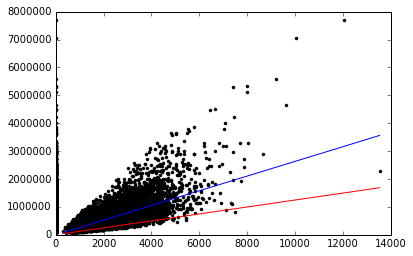

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

In [141]:
def rss(simple_feature_matrix, test_weight,output):
    res = predict_output(simple_feature_matrix, test_weight)-output
    res = sum(res*res)
    return(res)

print 'The initial weights (all zeros) %e:' % rss(simple_test_feature_matrix, initial_weights,test_output)
print 'The weights learned with no regularization %e:' % rss(simple_test_feature_matrix, simple_weights_0_penalty,test_output)
print 'The weights learned with high regularization %e:' % rss(simple_test_feature_matrix, simple_weights_high_penalty,test_output)

The initial weights (all zeros) 1.784273e+15:
The weights learned with no regularization 2.757238e+14:
The weights learned with high regularization 6.946537e+14:


In [155]:
model_features = ['sqft_living', 'sqft_living15']
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

print test_feature_matrix.shape


(4229L, 3L)


In [168]:
step_size = 1e-12
max_iterations = 1000

initial_weights = np.zeros(feature_matrix.shape[1])
print initial_weights

# Setting L2 = 0
l2_penalty = 0

multiple_weights_0_penalty= ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 
                                                             l2_penalty, max_iterations=100)
print '0 penalty', multiple_weights_0_penalty

l2_penalty = 1e11
multiple_weights_high_penalty= ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 
                                                             l2_penalty, max_iterations=100)

print 'large penalty', multiple_weights_high_penalty

[ 0.  0.  0.]
0 penalty [  3.83037308e-02   1.61114907e+02   1.11390685e+02]
large penalty [  0.25127369  91.48899895  78.43870199]


In [167]:
print 'The initial weights (all zeros) %e:' % rss(test_feature_matrix, initial_weights,test_output)
print 'The weights learned with no regularization %e:' % rss(test_feature_matrix, multiple_weights_0_penalty,test_output)
print 'The weights learned with high regularization %e:' % rss(test_feature_matrix, multiple_weights_high_penalty,test_output)

The initial weights (all zeros) 1.784273e+15:
The weights learned with no regularization 2.802588e+14:
The weights learned with high regularization 5.004087e+14:


In [166]:
print output[0], predict_output(test_feature_matrix[0,:], initial_weights), output[0]- predict_output(test_feature_matrix[0,:], initial_weights)
print output[0], predict_output(test_feature_matrix[0,:], multiple_weights_0_penalty), output[0]- predict_output(test_feature_matrix[0,:], multiple_weights_0_penalty)
print output[0], predict_output(test_feature_matrix[0,:], multiple_weights_high_penalty), output[0]-predict_output(test_feature_matrix[0,:], multiple_weights_high_penalty)

142000.0 0.0 142000.0
142000.0 208876.071349 -66876.0713493
142000.0 138959.041551 3040.95844917
